## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from text import text_to_sequence
from audio import init_stft, mel_spectrogram

from denoiser import Denoiser

import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/olehmatsuk/opt/anaconda3/envs/taco/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.show()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [3]:
waveglow_path = '../waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Load Model

In [4]:
models = {
    'base': '/Users/olehmatsuk/Thesis/runs/taco_Jul20_14_22_06/159',
    #'base2': '/Users/olehmatsuk/Thesis/runs/taco_Jul27_20_16_22/123',
    'k': '/Users/olehmatsuk/Thesis/runs/tacos_k_Jul27_22_17_17/120',
    'c': '/Users/olehmatsuk/Thesis/runs/tacos_c_Jul27_22_17_17/120',
    'ck': '/Users/olehmatsuk/Thesis/runs/tacos_ck_Jul27_22_17_17/120',
    'v': '/Users/olehmatsuk/Thesis/runs/tacos_v_Jul27_22_17_17/120',
    'k_w': '/Users/olehmatsuk/Thesis/runs/tacosw_k_Jul27_22_16_51/169',
    'c_w': '/Users/olehmatsuk/Thesis/runs/tacosw_c_Jul27_22_16_51/169',
    'ck_w': '/Users/olehmatsuk/Thesis/runs/tacosw_ck_Jul27_22_16_51/169',
    'v_w': '/Users/olehmatsuk/Thesis/runs/tacosw_v_Jul27_22_16_51/169'
}

speaker_encoders = {
    'k': '/Users/olehmatsuk/Thesis/runs/speaker_k_Jul04_23_08_52/checkpoint_80000',
    'c': '/Users/olehmatsuk/Thesis/runs/speaker_c_Jul04_23_05_50/checkpoint_196000',
    'ck': '/Users/olehmatsuk/Thesis/runs/speaker_ck_Jul04_23_23_32/checkpoint_180000',
    'v': '/Users/olehmatsuk/Thesis/runs/speaker_v_Jul04_23_05_50/checkpoint_216000',
}

In [5]:
c = 'v_w'
checkpoint_path = models[c]
speaker_encoder = speaker_encoders[c.split('_')[0]]

#hparams = create_hparams()
hparams = create_hparams('tacotron', f'speaker_encoder={speaker_encoder}')
model = Tacotron2(hparams)
if checkpoint_path is not None: 
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
model.eval()
print()

#### Prepare voice

In [6]:
def to_mel(audio):
    stft = init_stft(create_hparams())
    mel_input = mel_spectrogram(audio, stft)
    return mel_input

In [7]:
voices = [
    '/Users/olehmatsuk/Thesis/data/konekorpus/Birgit_Itse/20051201-1030ER_uudised_2005_12_01_10_00_129.376_134.599_planned_high.wav',
    '/Users/olehmatsuk/Thesis/data/konekorpus/Katarina/0001_art_9_lause_3.wav',
    '/Users/olehmatsuk/Thesis/data/konekorpus/Meelis_Kompus/20051204-1130ER_uudised_2005_12_04_11_00_140.515_146.56_planned_high_studio.wav',
    '/Users/olehmatsuk/Thesis/data/konekorpus/Tarmo_Maiberg/20051201-0630ER_uudised_2005_12_01_06_00_125.3_135.924_planned_high_studio.wav',
    '/Users/olehmatsuk/Thesis/data/vctk/wav48/p240/p240_023.wav',
    '/Users/olehmatsuk/Thesis/data/common_voice/et/clips/common_voice_et_18316950.mp3',
    '/Users/olehmatsuk/Downloads/oleh.mp3'
]

mels = [to_mel(v) for v in voices]

#### Infer

In [8]:
def infer(model, sequence, mel_input, denoise=True):
    with torch.no_grad():
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference((sequence.unsqueeze(0), mel_input.T.unsqueeze(0)))
        audio = waveglow.cpu().infer(mel_outputs_postnet.transpose(1, 2), sigma=0.666)[0]
        if denoise:
            audio = denoiser(audio.unsqueeze(0), strength=0.01)[:, 0]

    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    return ipd.Audio(audio.data.numpy(), rate=hparams.sampling_rate)

In [9]:
text = 'Politsei palub kõigil, kes märkavad kirjeldustele vastavat naist, helistada numbril üks üks kaks.'

sequence = torch.tensor(text_to_sequence(text, hparams.text_cleaners), dtype=torch.long)

In [10]:
ipd.Audio(voices[0])

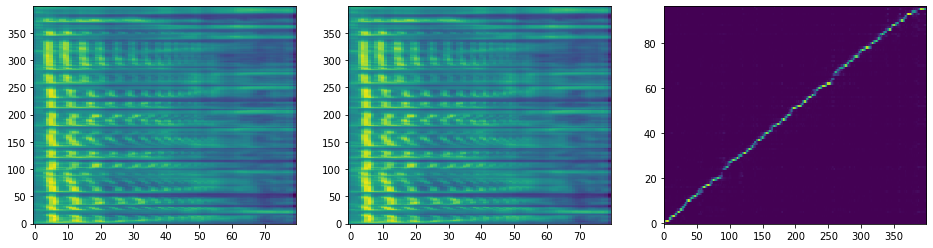

In [11]:
infer(model, sequence, mels[0])

In [12]:
ipd.Audio(voices[1])

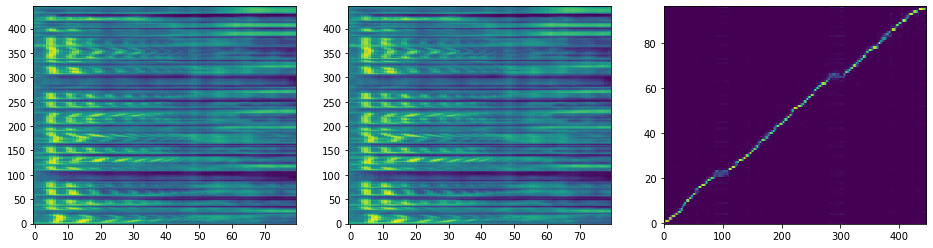

In [13]:
infer(model, sequence, mels[1])

In [14]:
ipd.Audio(voices[2])

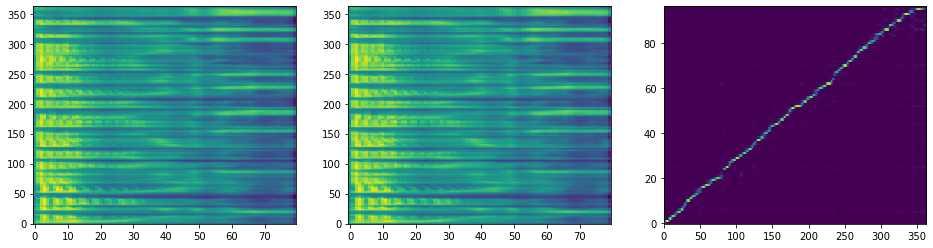

In [15]:
infer(model, sequence, mels[2])

In [16]:
ipd.Audio(voices[3])

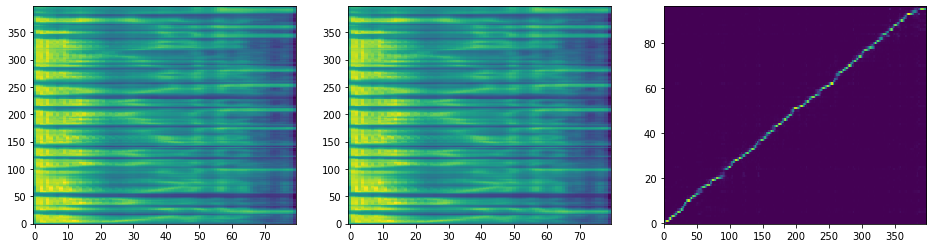

In [17]:
infer(model, sequence, mels[3])

In [18]:
ipd.Audio(voices[4])

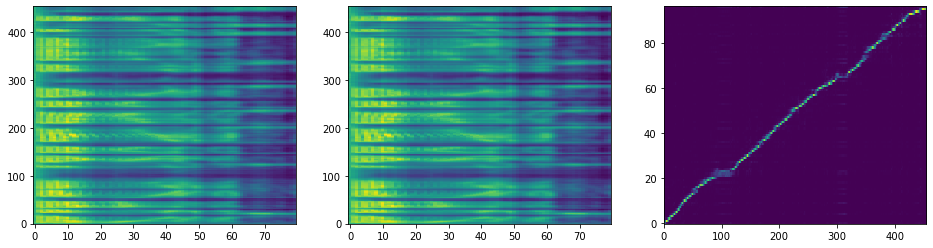

In [19]:
infer(model, sequence, mels[4])

In [20]:
ipd.Audio(voices[5])

Warning! Reached max decoder steps


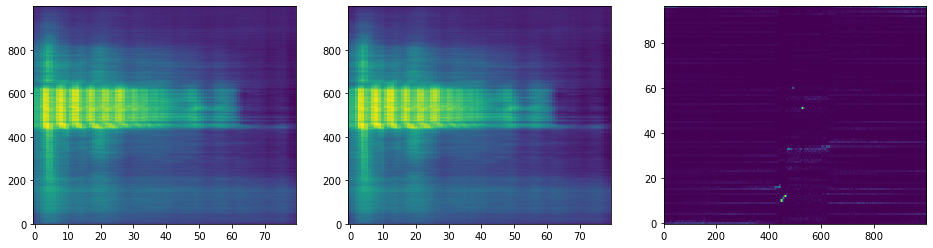

In [21]:
infer(model, sequence, mels[5])